In [1]:
%matplotlib inline
import matplotlib 
matplotlib.rcParams.update({'font.size': 16})
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import random
import os
import sys
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Need to split the data so that the popularity measure has the same
distribution between the test-train-validation datasets. This is tricky
as the popularity has a long-tail distribtuion.
"""

df = pd.read_csv(
    './dataset_csvs/msd-topMAGD-partition_fixedSizeSplit_2000-v1.0.cls',
    sep='\t', skiprows=17, names=['track', 'label']
    )
df = df.drop(['label'], axis=1)
df_genre= pd.read_csv('./dataset_csvs/msd-topMAGD-genreAssignment.cls',
    sep='\t', names=['track', 'genre'])
df_listens = pd.read_csv('./dataset_csvs/train_triplets.txt', sep='\t',
    names=['user', 'song', 'listens'])
df_listens = df_listens.groupby(['song'])['listens'].agg('sum').reset_index()
df_uniquetracks = pd.read_csv('./dataset_csvs/unique_tracks.txt', sep='<SEP>',
    names=['track', 'song', 'artist', 'songname'], engine='python', )
df = df.merge(df_genre, on='track')
df = df.merge(df_uniquetracks, on='track')
df = df.merge(df_listens, on='song', how='left')
df = df.fillna(0)

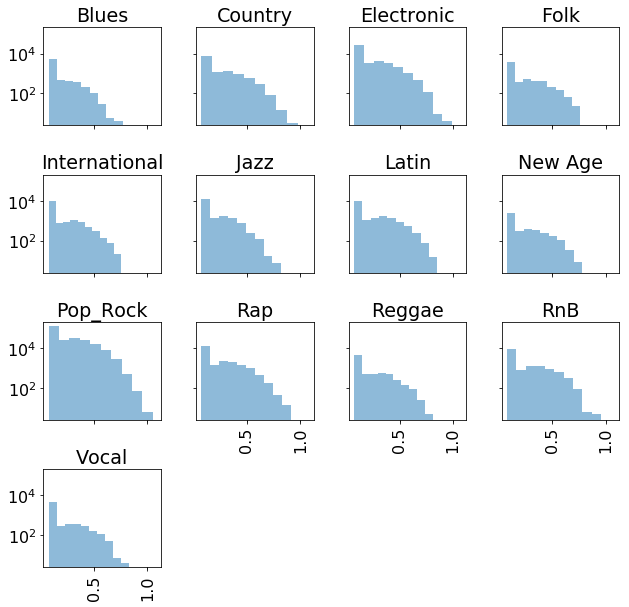

In [3]:
df['loglistens'] = [np.log(x+1) for x in list(df['listens'])]
m = df['loglistens'].max()
df['loglistens'] = [(x+1)/m for x in list(df['loglistens'])]
df.hist(column='loglistens', by='genre', alpha=0.5, bins=10, log=True,
    sharex=True, sharey=True, figsize=(10,10))
plt.show()

In [4]:
train = []
test = []
for name, group in df.groupby(['genre']):
    p = 3000/len(group)
    p2 = 1000/len(group)
    bins = np.linspace(group['loglistens'].min(), group['loglistens'].max()+1, 5)
    binned = group.groupby(np.digitize(group['loglistens'], bins))
    for binname, bindf in binned:
        num = math.ceil(p*len(bindf))
        num2 = math.ceil(p2*len(bindf))
        if len(bindf) == 2:
            num = 1
            num2 = 0
        indx = list(bindf.index)
        random.shuffle(list(bindf.index))
        train += indx[0:num]
        test += indx[num:num+num2]
traindf = df.iloc[train]
testdf = df.iloc[test]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


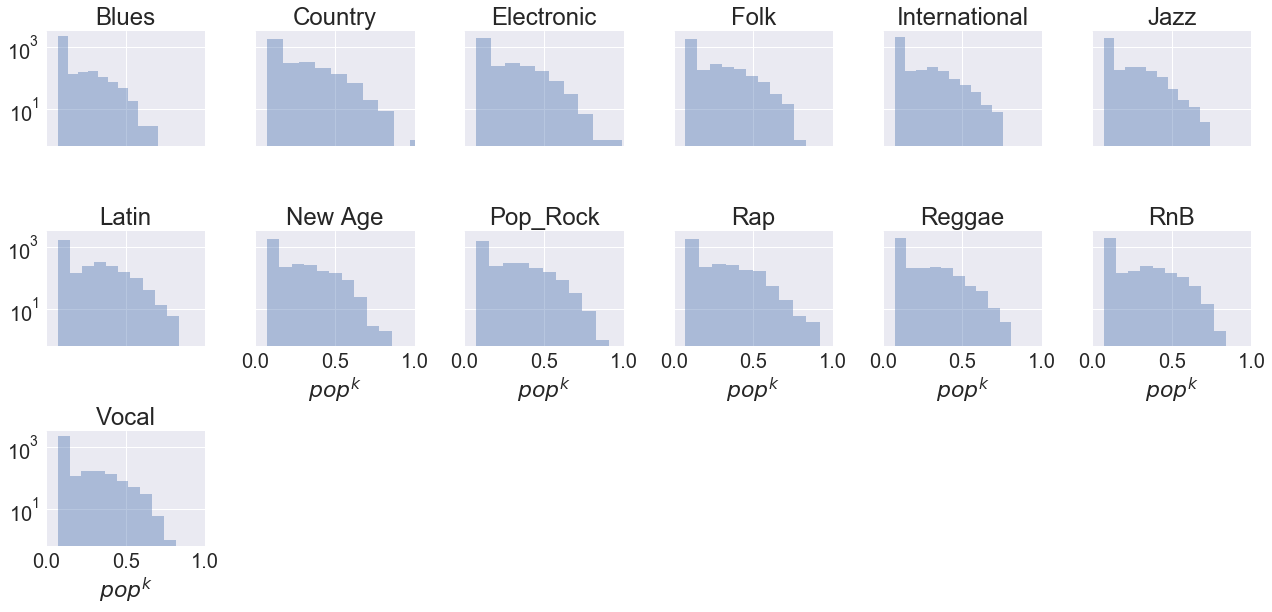

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


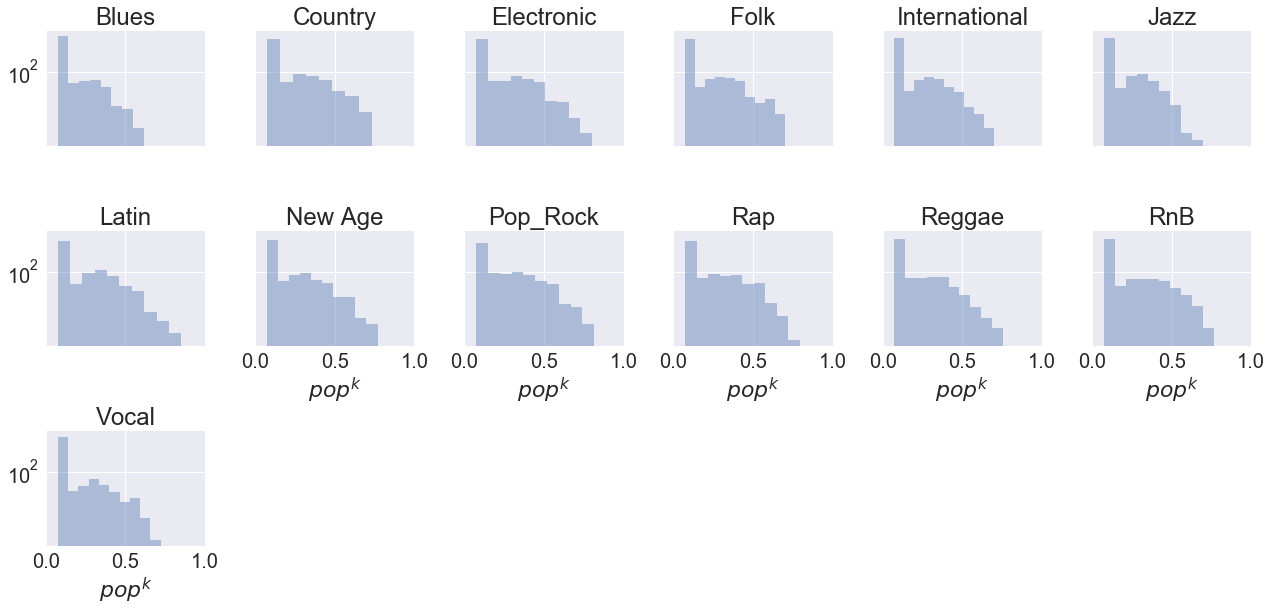

In [31]:
sns.set(font_scale=2)
traindf['$pop^{k}$'] = list(traindf['loglistens'])
#fig, ax = plt.subplots(figsize=(5, 5))
#traindf.hist(column='amount', by='label', ax=ax, alpha=0.5, bins=10, log=True, sharex=True, sharey=True)
g = sns.FacetGrid(traindf, col='genre', col_wrap=6)
g.map(sns.distplot, "$pop^{k}$", rug=False, kde=False, norm_hist=False, bins=10, hist_kws={'log':True})
axes = g.axes
for ax in axes:
    t = ax.get_title()
    t = t.replace("genre = ", "")
    ax.set_title(t)
#axes[0].set_ylim([0, 300])
#axes[1].set_ylim([0, 300])
axes[0].set_xlim([0, 1])
#axes[1].set_xlim([0, 17000])
g.savefig('train_dist.png')
plt.show()

testdf['$pop^{k}$'] = list(testdf['loglistens'])
g2 = sns.FacetGrid(testdf, col='genre', col_wrap=6)
g2.map(sns.distplot, "$pop^{k}$", rug=False, kde=False, norm_hist=False, bins=10, hist_kws={'log':True})
axes = g2.axes
for ax in axes:
    t = ax.get_title()
    t = t.replace("genre = ", "")
    ax.set_title(t)
#axes[0].set_ylim([0, 100])
#axes[1].set_ylim([0, 100])
axes[0].set_xlim([0, 1])
#axes[1].set_xlim([0, 17000])
g2.savefig('test_dist.png')
plt.show()

AttributeError: Unknown property column

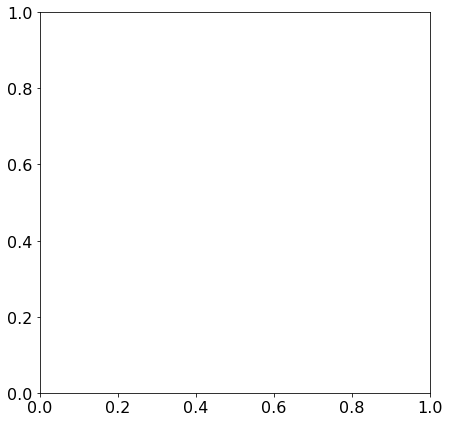

In [5]:
# Sanity check to make sure train and test dataset do not share any rows
merge = pd.merge(traindf, testdf, how='inner')
print(len(merge))

Now that we have created dataframes for both the training and testing dataset, we need to load the corresponding chromagrams from the Million Song Dataset for both dataframes.

In [3]:
# Adding the python code for hdf5_getters to load attributes from the Million Song Dataset
pythonsrc = 'C:/Users/Alex/Documents/Python/MSongsDB/PythonSrc'
pythonsrc = os.path.abspath(pythonsrc)
sys.path.append(pythonsrc)
from hdf5_getters import *

def get_chroma(path):
    h5 = open_h5_file_read(path)
    chroma = get_segments_pitches(h5).astype(np.float32)
    h5.close()
    return chroma

def get_chromas(df, dirs):
    tracks = df['track']
    chromas = [get_chroma(dirs[t]) for t in tqdm(tracks)]
    return chromas

def get_timbre(path):
    h5 = open_h5_file_read(path)
    timbre = get_segments_timbre(h5).astype(np.float32)
    h5.close()
    return timbre

def get_timbres(df, dirs):
    tracks = df['track']
    timbres = [get_timbre(dirs[t]) for t in tqdm(tracks)]
    return timbres

# A dictionary that maps track IDs from the Million Song Dataset to the corresponding h5 file stored locally.
with open('ids-to-dirs.pickle', 'rb') as f:
    dir_dict = pickle.load(f)

traindf['chroma'] = get_chromas(traindf, dir_dict)
testdf['chroma'] = get_chromas(testdf, dir_dict)

In [7]:
#traindf = pd.read_hdf('train.h5', 'df')
testdf = pd.read_hdf('test.h5', 'df')

testimbres = get_timbres(testdf, dir_dict)
sess = tf.InteractiveSession()

testtimbre = [np.expand_dims(c, axis=2) for c in testimbres]
testtimbre = [(tf.image.resize_images(c, [500, 12])) for c in tqdm(testtimbre)]
testtimbre = tf.stack(testtimbre).eval()
np.save('testtimbres_resized.npy', testtimbre)
print('test finished')


traintimbre = [np.expand_dims(c, axis=2) for c in traintimbres]
traintimbre = [(tf.image.resize_images(c, [500, 12])) for c in tqdm(traintimbre)]
traintimbre = tf.stack(traintimbre).eval()
np.save('traintimbres_resize.npy', traintimbre)
print('train finished')

100%|█████████████████████████████████████████████████████████████████████████████████████████| 13012/13012 [00:25<00:00, 516.86it/s]


test finished


In [6]:
traindf['timbre'] = [c for c in traintimbre]
traindf.to_hdf('train_5.h5', 'df')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['track', 'genre', 'song', 'artist', 'songname', 'chroma', 'timbre']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [9]:
testdf = pd.read_hdf('test.h5', 'df')
t1 = list(np.load('testtimbres_resized.npy'))
t2 = list(testdf['chroma'])

stack = []
for i in tqdm(range(0, len(t1))):
    stack.append(np.vstack([t1[i], t2[i]]))
print(len(stack))

np.save('teststack.npy', np.asarray(stack))

100%|███████████████████████████████████████████████████████████████████████████████████████| 13012/13012 [00:00<00:00, 49342.43it/s]


13012


In [5]:
traindf  = pd.read_hdf('train.h5', 'df')
traindf['chroma'] = [c for c in np.load('trainstack.npy')]
traindf.to_hdf('train_h5.h5', 'df')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['track', 'genre', 'song', 'artist', 'songname', 'chroma']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
